In [2]:
import keras
from keras.layers import Input, Dense
from keras.models import Model
from keras.utils import plot_model
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import TimeDistributed,Activation

from keras.layers import LSTM
from keras.layers import SimpleRNN
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.embeddings import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.utils import to_categorical
# from keras import backend as K
# K.tensorflow_backend._get_available_gpus()

# ***** Actual required Design for the model *******

In [43]:
max_input_length=30
embedding_dim=300
vocab_size=23138
hidden_dim=200
pos_tag_size=38


main_input = Input(shape=(max_input_length,), dtype='float32', name='main_input')

# This embedding layer will encode the input sequence
# into a sequence of dense 512-dimensional vectors.
x = Embedding(output_dim=embedding_dim, input_dim=vocab_size, input_length=max_input_length,name="embedding")(main_input)

# A LSTM will transform the vector sequence into a single vector,
# containing information about the entire sequence
lstm_out,state_h, state_c = LSTM(hidden_dim,return_sequences=True, return_state=True,name="LSTM")(x)
print(lstm_out.shape)

auxiliary_output = TimeDistributed(Dense(pos_tag_size, activation='sigmoid'), name='POS_output')(lstm_out)

# auxiliary_output = Dense(1, activation='sigmoid', name='aux_output')(lstm_out)

# auxiliary_input = Input(shape=(5,), name='aux_input')
# x = keras.layers.concatenate([lstm_out, auxiliary_input])


# We stack a deep densely-connected network on top
x = Dense(400, activation='relu',name="dense")(state_h)
# x = Dense(64, activation='relu')(x)
# x = Dense(64, activation='relu')(x)

# And finally we add the main logistic regression layer
main_output = Dense(vocab_size, activation='sigmoid', name='LM_output')(x)

phase1_model= Model(inputs=[main_input], outputs=[main_output])
phase2_model = Model(inputs=[main_input], outputs=[main_output, auxiliary_output])

(?, ?, 200)


# Compiling the models

In [44]:
phase2_model.compile(loss={'LM_output': 'categorical_crossentropy', 'POS_output': 'mse'},optimizer='rmsprop',metrics=['accuracy'])
phase1_model.compile(loss={'LM_output': 'categorical_crossentropy'},optimizer='rmsprop',metrics=['accuracy'])

# model.compile(optimizer='rmsprop',
#               loss={'main_output': 'binary_crossentropy', 'aux_output': 'binary_crossentropy'},
#               loss_weights={'main_output': 1., 'aux_output': 0.2})


# Save the models to image files and display them

In [45]:
plot_model(phase1_model,to_file='phase1_model_mine.png',show_shapes=True)
plot_model(phase2_model,to_file='phase2_model_mine.png',show_shapes=True)


# Phase 1 model architecture

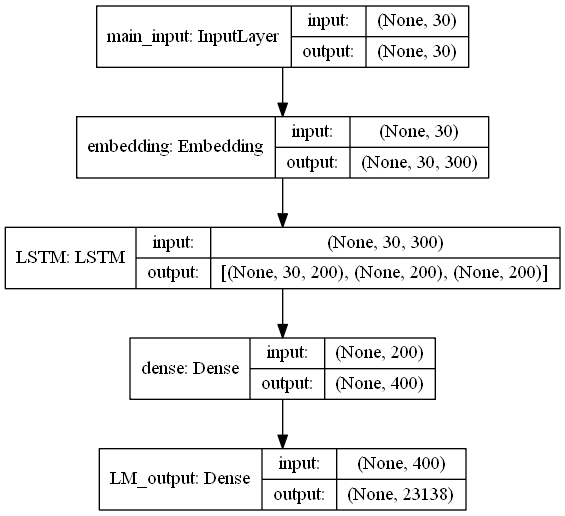

In [46]:
from IPython.display import Image
Image("phase1_model_mine.png")


# Phase 2 model architecture

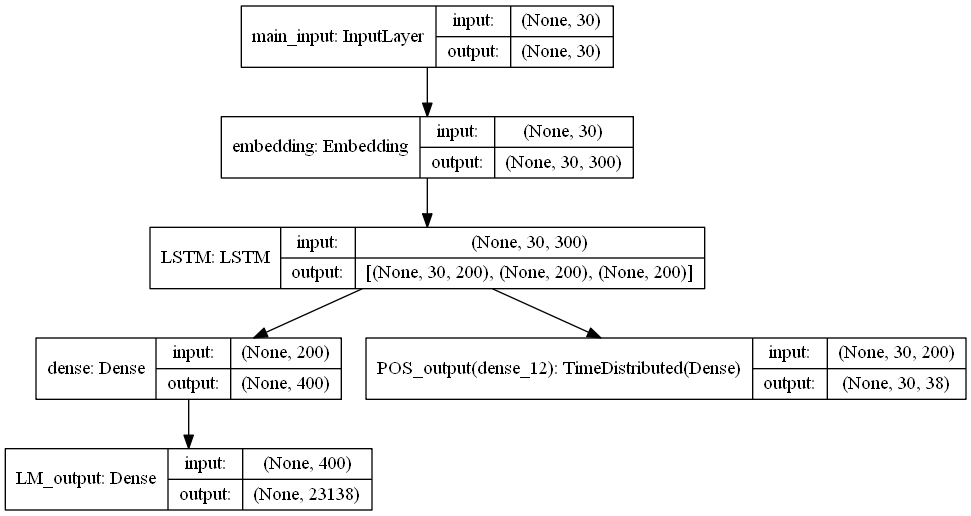

In [47]:
Image("phase2_model_mine.png")

# Creating random data. Phase 2 y label has (100, 30, 38) shape. Phase 1 y label has (100, 23138). X has (100,30). 30 is the time sequences. 23138 is vocab size.

# 38 is the number of pos tags 


In [63]:
import numpy as np
TRAIN_SIZE = 100
# x=np.random.uniform(0, 10, (TRAIN_SIZE, 2))
x=np.random.randint(10, size=(TRAIN_SIZE,30))
print("x is ",x[0])
print("x shape is ",x.shape)
phase2_y=np.random.randint(10, size=(TRAIN_SIZE,30))
phase1_Y=np.random.randint(10, size=TRAIN_SIZE)
phase1_Y=to_categorical(phase1_Y,23138)
print(phase2_y[0])

sequences = [to_categorical(y, num_classes=38) for y in phase2_y]
phase2_y = array(sequences)


# print(phase1_Y[0])

# print(len(x))
# print(len(phase1_Y))
print(phase2_y[0])
print(phase2_y.shape)
print(phase1_Y.shape)

x is  [0 9 1 5 6 9 8 1 2 0 0 3 6 8 4 3 8 8 2 6 4 4 3 3 0 3 3 7 1 8]
x shape is  (100, 30)
[4 3 1 2 0 3 7 8 4 4 2 4 8 8 6 4 6 9 5 4 5 7 0 9 9 7 4 4 7 1]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]]
(100, 30, 38)
(100, 23138)


# Fitting the data to phase1 model(Language model).

In [64]:
phase1_model.fit(x,{'LM_output':phase1_Y},epochs=20)

Epoch 1/20
100/100 [==============================] - 1s - loss: 2.3075 - acc: 0.1500     
Epoch 2/20
100/100 [==============================] - 0s - loss: 2.3758 - acc: 0.2000     
Epoch 3/20
100/100 [==============================] - 0s - loss: 2.3584 - acc: 0.2000     
Epoch 4/20
100/100 [==============================] - 0s - loss: 2.3041 - acc: 0.2000     
Epoch 5/20
100/100 [==============================] - ETA: 0s - loss: 2.3001 - acc: 0.208 - 0s - loss: 2.2967 - acc: 0.2000     
Epoch 6/20
100/100 [==============================] - 0s - loss: 2.2677 - acc: 0.2000     
Epoch 7/20
100/100 [==============================] - 0s - loss: 2.3292 - acc: 0.2000     
Epoch 8/20
100/100 [==============================] - 0s - loss: 2.2691 - acc: 0.2000     
Epoch 9/20
100/100 [==============================] - 0s - loss: 2.2700 - acc: 0.2000     
Epoch 10/20
100/100 [==============================] - 0s - loss: 2.2691 - acc: 0.2000     
Epoch 11/20
100/100 [==============================

# Store the weights of phase 1 model's layers

In [51]:
phase1_model_weights = [(layer.name,layer.get_weights()) for layer in phase1_model.layers]

In [53]:
for w in phase1_model_weights:
    print(w)

('main_input', [])
('embedding', [array([[-1.6045192e-02, -7.3762268e-02,  1.3003504e-05, ...,
        -4.6659123e-02,  7.7813335e-02, -7.6717049e-02],
       [-4.0676296e-02, -5.7529937e-02,  2.9663283e-02, ...,
        -2.5084363e-02,  8.0328226e-02, -7.3849589e-02],
       [-2.8132960e-02, -5.4108884e-02,  5.8001999e-02, ...,
        -4.5571625e-02,  7.9032294e-02, -6.8271630e-02],
       ...,
       [-4.8725914e-02,  4.5663301e-02, -4.8879709e-02, ...,
         4.7265146e-02,  1.8351760e-02, -4.3571532e-02],
       [ 4.3648709e-02, -1.9679463e-02,  7.5322166e-03, ...,
         3.5398696e-02, -4.7075581e-02,  2.3312058e-02],
       [ 4.5996759e-02,  1.5598536e-04, -4.3894555e-02, ...,
        -5.3900480e-03, -1.6503356e-02, -8.8486299e-03]], dtype=float32)])
('LSTM', [array([[-0.03903427,  0.01339157,  0.01788686, ..., -0.09029618,
        -0.08861809, -0.04863692],
       [-0.12638824, -0.06965843, -0.04469473, ..., -0.0479775 ,
        -0.06977989, -0.04357312],
       [ 0.1041970

# For every phase1 model layer that is present in phase2, we assign the stored 

# weights to the corresponding layers.

In [65]:
for i in range(len(phase1_model_weights)):
    if not phase2_model.get_layer(phase1_model_weights[i][0])==None:
        print(phase1_model_weights[i][0]," layer weights are assigned ")
        phase2_model.get_layer(phase1_model_weights[i][0]).set_weights(phase1_model_weights[i][1])
    else:
        print(phase1_model_weights[i][0]," layer with weights ",phase1_model_weights[i][1]," are not copied")

main_input  layer weights are assigned 
embedding  layer weights are assigned 
LSTM  layer weights are assigned 
dense  layer weights are assigned 
LM_output  layer weights are assigned 


In [66]:
# model.add(Activation('softmax'))

phase2_model.fit(x,{'LM_output':phase1_Y,'POS_output':phase2_y},epochs=20)

Epoch 1/20
100/100 [==============================] - 0s - loss: 2.3301 - LM_output_loss: 2.3052 - POS_output_loss: 0.0249 - LM_output_acc: 0.1800 - POS_output_acc: 0.1113     
Epoch 2/20
100/100 [==============================] - 0s - loss: 2.3287 - LM_output_loss: 2.3045 - POS_output_loss: 0.0242 - LM_output_acc: 0.0600 - POS_output_acc: 0.1013       
Epoch 3/20
100/100 [==============================] - 0s - loss: 2.3272 - LM_output_loss: 2.3031 - POS_output_loss: 0.0241 - LM_output_acc: 0.1100 - POS_output_acc: 0.0973     
Epoch 4/20
100/100 [==============================] - 0s - loss: 2.3268 - LM_output_loss: 2.3028 - POS_output_loss: 0.0240 - LM_output_acc: 0.2000 - POS_output_acc: 0.0997     
Epoch 5/20
100/100 [==============================] - 0s - loss: 2.3268 - LM_output_loss: 2.3029 - POS_output_loss: 0.0239 - LM_output_acc: 0.2000 - POS_output_acc: 0.1050     
Epoch 6/20
100/100 [==============================] - 0s - loss: 2.3266 - LM_output_loss: 2.3027 - POS_output_los

# < E O Required Model>

In [13]:
temp_weights = [(layer.name,layer.get_weights()) for layer in model.layers]

In [15]:
for w in temp_weights:
    print(w)

('main_input', [])
('embedding_2', [array([[-0.00279286,  0.04029224,  0.01855215, ..., -0.0484264 ,
         0.04315709,  0.02625224],
       [-0.01170618,  0.00011686, -0.01941552, ...,  0.04837949,
         0.04512906, -0.01941352],
       [-0.02877388,  0.02374394, -0.04693095, ...,  0.04077431,
         0.01061218,  0.0062535 ],
       ...,
       [ 0.04366018,  0.04529333,  0.02831726, ..., -0.03876262,
         0.00316662, -0.03918944],
       [ 0.03157641,  0.02038043, -0.00162188, ...,  0.00468414,
        -0.01748624,  0.02393098],
       [-0.0239184 , -0.03490951,  0.00585748, ..., -0.01446408,
        -0.0489972 ,  0.01092162]], dtype=float32)])
('lstm_3', [array([[ 0.05601099,  0.05248825,  0.03209231, ..., -0.00892116,
        -0.05655447, -0.06374846],
       [-0.06517488,  0.07184283, -0.06934532, ...,  0.05703861,
        -0.02104235,  0.06149983],
       [-0.01235568, -0.02432105,  0.01969068, ...,  0.05696215,
        -0.04665165,  0.03583196],
       ...,
       [-0

In [ ]:
for i in range(len(temp_weights)):
    model.layers[i].set_weights(temp_weights[i])
    
# model.get_layer("aux_output")